Important imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from augment_rot import augment_with_rotations
from nn import build_pointnet
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [9]:
def train_model(model, train_points, train_labels, test_points, test_labels, epochs=10, batch_size=32):
    # Convertir les labels en one-hot encoding
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)
    
    # Compiler le modèle
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entraîner le modèle
    history = model.fit(train_points, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_points, test_labels), verbose=0)
    
    # Retourner l'accuracy sur l'ensemble de validation
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

In [10]:
# Charger les données d'entraînement et de test
train_data = np.load("./data_numpy/train_data.npz")
train_points = train_data["train_points"]
train_labels = train_data["train_labels"]

test_data = np.load("./data_numpy/test_data.npz")
test_points = test_data["test_points"]
test_labels = test_data["test_labels"]

# Inspecter les étiquettes
print("Étiquettes d'entraînement:", np.unique(train_labels))
print("Étiquettes de test:", np.unique(test_labels))

# Normaliser les étiquettes pour qu'elles soient dans la plage [0, 9]
train_labels = train_labels - 2
test_labels = test_labels - 2

# Vérifiez les étiquettes après normalisation
print("Étiquettes d'entraînement après normalisation:", np.unique(train_labels))
print("Étiquettes de test après normalisation:", np.unique(test_labels))


Étiquettes d'entraînement: [ 2  3  4  5  6  7  8  9 10 11]
Étiquettes de test: [ 2  3  4  5  6  7  8  9 10 11]
Étiquettes d'entraînement après normalisation: [0 1 2 3 4 5 6 7 8 9]
Étiquettes de test après normalisation: [0 1 2 3 4 5 6 7 8 9]


shape train points sampled:  (199,)
Training with 1 duplicates (random rotations)...
start training....
finished training
Training with 1 duplicates (fixed rotations)...
start training
ended training
Training with 2 duplicates (random rotations)...
start training....
finished training
Training with 2 duplicates (fixed rotations)...
start training
ended training


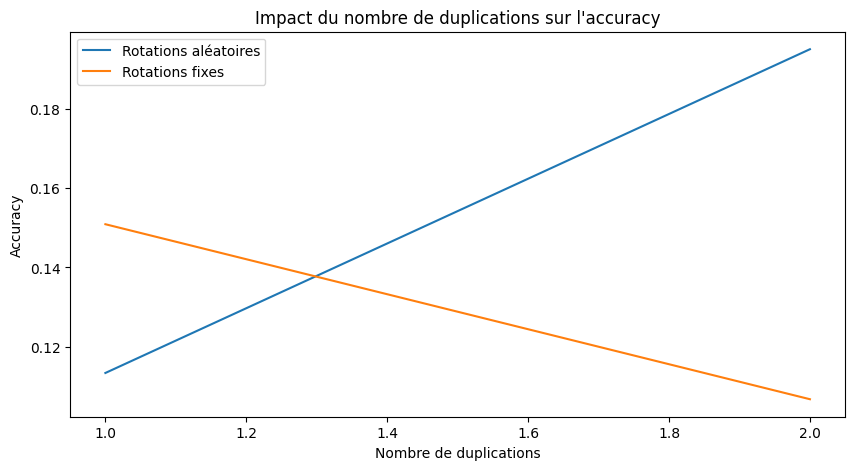

In [13]:
# n_duplicates_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n_duplicates_list = [1,2]
random_accuracy = []
fixed_accuracy = []

# Échantillonner une fraction des données d'entraînement (5% ici)
fraction = 0.05
indices = np.random.choice(train_points.shape[0], size=int(fraction * train_points.shape[0]), replace=False)
train_points_sampled = train_points[indices]
train_labels_sampled = train_labels[indices]
print('shape train points sampled: ', train_labels_sampled.shape)

for n in n_duplicates_list:
    print(f"Training with {n} duplicates (random rotations)...")
    model_random = build_pointnet()
    aug_train_points, aug_train_labels = augment_with_rotations(train_points_sampled, train_labels_sampled, number_of_duplicates=n, random_rotation=True)
    print('start training....')
    acc_random = train_model(model_random, aug_train_points, aug_train_labels, test_points, test_labels, epochs=1, batch_size=32)
    print('finished training')
    random_accuracy.append(acc_random)

    print(f"Training with {n} duplicates (fixed rotations)...")
    model_fixed = build_pointnet()
    aug_train_points, aug_train_labels = augment_with_rotations(train_points_sampled, train_labels_sampled, number_of_duplicates=n, random_rotation=False)
    print('start training')
    acc_fixed = train_model(model_fixed, aug_train_points, aug_train_labels, test_points, test_labels, epochs=1, batch_size=32)
    print('ended training')
    fixed_accuracy.append(acc_fixed)

# Tracer les résultats
plt.figure(figsize=(10, 5))
plt.plot(n_duplicates_list, random_accuracy, label="Rotations aléatoires")
plt.plot(n_duplicates_list, fixed_accuracy, label="Rotations fixes")
plt.xlabel("Nombre de duplications")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Impact du nombre de duplications sur l'accuracy")
plt.show()